<a href="https://colab.research.google.com/github/janwaelty/Master-Thesis/blob/main/data_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import torch

from scipy.stats import linregress
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import shutil
import os
from google.colab import drive
import zipfile

In [31]:
def plot_avg_sale_prices_over_time(df, date_column='transaction_year_semi', price_column='transaction_price'):
    """
    Plots the average sale prices over time.

    Parameters:
    df (DataFrame): The dataset containing sales transactions.
    date_column (str): The column representing transaction year.
    price_column (str): The column representing sale price.
    """
    # Convert to DataFrame (if not already)
    df = pd.DataFrame(df)

    # Group by year and compute the average sale price
    avg_prices = df.groupby(date_column)[price_column].mean()

    # Plot the trend
    plt.figure(figsize=(12, 6))
    plt.plot(avg_prices.index, np.log(avg_prices.values), marker='o', linestyle='-', color='blue', label="Average Sale Price")
    plt.xlabel("Year of Sale")
    plt.ylabel("Average Transaction Price")
    plt.title("Average Transaction Prices Over Time")
    plt.grid(True)
    plt.legend()

    plt.show()

def plot_categorical_features(data, categorical_columns):

    # Visualize distribution of categorical variables
    fig, axes = plt.subplots(1, len(categorical_columns), figsize=(15, 5))

    for i, column in enumerate(categorical_columns):
        ax = axes[i]
        sns.countplot(x=column, data=data, ax=ax)
        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

def repeated_to_single_transactions(data):
    """
    Transforms a dataset by splitting purchase and sale data into separate rows
    and renaming columns for consistency.
    """

    df = data.copy().dropna()
    # Columns to keep (common info)

    common_columns = ['category', 'artist', 'height', 'width', 'medium', 'image_url']


    # Sale Data: Keep only relevant columns
    sale_data = df[common_columns + ['sale_year_semi', 'sale_price',
                                     'sale_house', 'sale_date']].copy()
    sale_data = sale_data.rename(columns={
        'sale_year_semi': 'transaction_year_semi',
        'sale_price': 'transaction_price',
        'sale_house': 'transaction_house',
        'sale_date': 'transaction_date'

    })


    # Purchase Data: Keep only relevant columns
    purchase_data = df[common_columns + ['purchase_year_semi', 'purchase_price',
                                         'purchase_house', 'purchase_date']].copy()
    purchase_data = purchase_data.rename(columns={
        'purchase_year_semi': 'transaction_year_semi',
        'purchase_price': 'transaction_price',
        'purchase_house': 'transaction_house',
        'purchase_date': 'transaction_date'
        })

    df_final = pd.concat([sale_data, purchase_data], ignore_index=True)
    #df_final  = df.drop_duplicates(subset=['image_url'], keep='first')

    return df_final


def one_hot(data, one_hot_vars):

  # Make a copy of the dataframe to avoid modifying the original data
  df = data.copy()

  # Perform one-hot encoding only on the specified columns (excluding 'image_url')
  df_encoded = pd.get_dummies(df, columns=one_hot_vars, drop_first=True)

  # Ensure that only the numeric columns are converted to integers
  for col in df_encoded.select_dtypes(include=['float64', 'int64']).columns:
     df_encoded[col] = df_encoded[col].astype(int)

  return df_encoded




def data_filter(data, selected_vars, min_price=5000, max_price = 20000000,min_house_occurence=100, min_artist_occurence=10):

    df = data.copy()
    # Filter the transaction_price column
    df = df[(df['transaction_price'] >= min_price) & (df['transaction_price'] <= max_price)]

    # Filter houses based on minimum occurrence
    house_counts = df['transaction_house'].value_counts()
    valid_houses = house_counts[house_counts >= min_house_occurence].index
    df = df[df['transaction_house'].isin(valid_houses)]

    # Filter artists based on minimum occurrence
    artist_counts = df['artist'].value_counts()
    valid_artists = artist_counts[artist_counts >= min_artist_occurence].index
    df = df[df['artist'].isin(valid_artists)]

    # Return the dataframe with only the selected variables
    return df[selected_vars]

def data_split(data, selected_vars, one_hot_vars, date_filter, one_hot_encoding=True):
    df = data.copy()
    df = repeated_to_single_transactions(df)
    df = data_filter(df, selected_vars)

    df = add_prev_avg_price(df)
    df = add_global_prev_avg_price(df)


    if one_hot_encoding:
        df = one_hot(df, one_hot_vars)

    train_data = df[df['transaction_year_semi'] < date_filter]
    test_data = df[df['transaction_year_semi'] >= date_filter]



    X_train = train_data.drop(columns=['transaction_price', 'transaction_year_semi'])
    y_train = np.log(train_data['transaction_price'])
    X_test = test_data.drop(columns=['transaction_price', 'transaction_year_semi'])
    y_test = np.log(test_data['transaction_price'])



    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

    # Ensure numerical scaling
    numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
    scaler_X = StandardScaler()
    X_train[numerical_features] = scaler_X.fit_transform(X_train[numerical_features])
    X_test[numerical_features] = scaler_X.transform(X_test[numerical_features])

    return X_train, X_test, y_train, y_test




def fit_visualization(X, y):
    target = np.array(X, dtype=np.float64)
    prediction_numerical_model = np.array(y, dtype=np.float64)

    # Compute R-squared using sklearn
    r_squared = r2_score(target, prediction_numerical_model)
    print(f"R-squared: {r_squared:.3f}")

    # Compute regression line parameters using linregress
    slope, intercept, r_value, p_value, std_err = linregress(target, prediction_numerical_model)

    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(target, prediction_numerical_model, alpha=0.5, label='Predictions')

    # Plot the regression line
    plt.plot(target, slope * target + intercept, color='black', label=f'Regression Line (R²={r_squared:.3f})')

    # Plot y=x line (perfect predictions)
    plt.plot([min(target), max(target)], [min(target), max(target)], color='green', linestyle='--', label='Perfect Prediction')

    # Labels and title
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True vs Predicted Transaction Prices')
    plt.legend()

    # Annotate the regression equation on the plot
    equation_text = f"y = {slope:.3f}x + {intercept:.3f}"
    plt.text(min(target), max(prediction_numerical_model) * 0.9, equation_text, fontsize=12, color='black')

    # Show the plot
    plt.show()

def load_image_data(zip_path, image_path):

  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    file_list = zip_ref.namelist()
    file_list = [f for f in file_list if not f.startswith('__MACOSX')]
    zip_ref.extractall(image_path, members=file_list)
  print(f"Dateien entpackt in: {image_path}")


# Function to check if an image file exists
def check_image_existence(image_paths, base_dir):
    missing_images = []  # To store paths of missing images
    nans = 0
    invalid_url = 0
    for image_path in image_paths:
        # Skip if the path is not a valid string (e.g., NaN or None)
        if isinstance(image_path, str) and image_path.strip():  # Check if it's a valid non-empty string
            # Construct the full image path based on the base directory
            full_image_path = os.path.join(base_dir, image_path.lstrip('/'))  # Remove leading slash, if any

            # Check if the file exists
            if not os.path.exists(full_image_path):
                missing_images.append(full_image_path)  # Add to missing list if not found
                invalid_url += 1
        else:
            nans += 1
    print(f"number of nans: {nans}")
    print(f"missing images: {invalid_url}")
    return missing_images

def filter_data_for_missing_images(data, missing_images, base_dir):
    # Extract only relative paths from missing_images
    data = data.dropna(subset=['image_url'])
    missing_relative_paths = [os.path.relpath(img, base_dir) for img in missing_images]
    data_filtered = data[~data['image_url'].str.lstrip('/').isin(missing_relative_paths)]

    return data_filtered

def resnet_transform():
    # Define the transformation pipeline
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),  # Convert PIL image to PyTorch tensor

        # Convert the image to RGB if it has an alpha channel
        torchvision.transforms.Lambda(lambda image: image[:3, :, :] if image.shape[0] == 4 else image),

        # Normalize using the ResNet50's mean and standard deviation
        torchvision.transforms.Normalize((0.485,0.456, 0.406),
                                         (0.229,0.224,0.225))
    ])
    return transform

def column_type_split(x_train, x_test, numerical_cols):
    """
    Returns numerical and one-hot encoded columns separately (used for projection)

    This function works with x_train and x_test, merging their respective columns.
    """
    # Copy x_train and x_test to avoid changing them in place
    train_df = x_train.copy()
    test_df = x_test.copy()

    # Identify the column types in both datasets
    artist_cols_train = [col for col in train_df.columns if col.startswith('artist_')]
    medium_cols_train = [col for col in train_df.columns if col.startswith('medium_')]
    transaction_house_cols_train = [col for col in train_df.columns if col.startswith('transaction_house_')]

    artist_cols_test = [col for col in test_df.columns if col.startswith('artist_')]
    medium_cols_test = [col for col in test_df.columns if col.startswith('medium_')]
    transaction_house_cols_test = [col for col in test_df.columns if col.startswith('transaction_house_')]

    # Merge the respective columns from both x_train and x_test
    artist_cols = list(set(artist_cols_train) | set(artist_cols_test))
    medium_cols = list(set(medium_cols_train) | set(medium_cols_test))
    transaction_house_cols = list(set(transaction_house_cols_train) | set(transaction_house_cols_test))

    return numerical_cols, artist_cols, medium_cols, transaction_house_cols




def add_prev_avg_price(data, artist_column='artist', date_column='transaction_date', price_column='transaction_price', shift=5):
    df = data.copy()

    try:
        df[date_column] = pd.to_datetime(df[date_column], format='%m/%d/%Y', errors='coerce')
    except ValueError:
        # If the specified format fails, try inferring the format
        df[date_column] = pd.to_datetime(df[date_column], errors='coerce')

    # Sort by artist and date to ensure correct order for rolling window
    df = df.sort_values(by=[artist_column, date_column])

    # Group by artist
    artist_groups = df.groupby(artist_column)

    # Initialize the 'prev_avg_price' column
    df['prev_avg_price'] = np.nan

    # Loop through each artist's group to compute the rolling average
    for artist, group in artist_groups:
        # Calculate the rolling average for the last 5 transactions
        if len(group) >= 6:  # Check if enough data for rolling window
            # Calculate using shift to avoid including the current row
            group['prev_avg_price'] = group[price_column].shift(1).rolling(window=shift).mean()

            # Apply log transformation (log(average)) while leaving NaNs unchanged
            group['prev_avg_price'] = np.log(group['prev_avg_price'])

        # Instead of df.loc, use group to update 'prev_avg_price' in the main dataframe
        df.loc[group.index, 'prev_avg_price'] = group['prev_avg_price'].values

    # Drop rows with NaN values only after all groups are processed
    df.dropna(subset=['prev_avg_price'], inplace=True)

    return df

def add_global_prev_avg_price(data, date_column='transaction_date', price_column='transaction_price', shift=5):
    df = data.copy()

    try:
        df[date_column] = pd.to_datetime(df[date_column], format='%m/%d/%Y', errors='coerce')
    except ValueError:
        # If the specified format fails, try inferring the format
        df[date_column] = pd.to_datetime(df[date_column], errors='coerce')

    # Sort by date to ensure correct order for rolling window
    df = df.sort_values(by=[date_column])

    # Calculate the rolling average for the last 5 transactions globally (not by artist)
    df['prev_global_avg_price'] = df[price_column].shift(1).rolling(window=shift).mean()

    # Apply log transformation (log(average)) with a small constant to avoid log(0)
    df['prev_global_avg_price'] = np.log(df['prev_global_avg_price'])

    # Drop rows with NaN values after applying the rolling average and log transformation
    df.dropna(subset=['prev_global_avg_price'], inplace=True)

    return df




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(39029, 27)
(75606, 10)


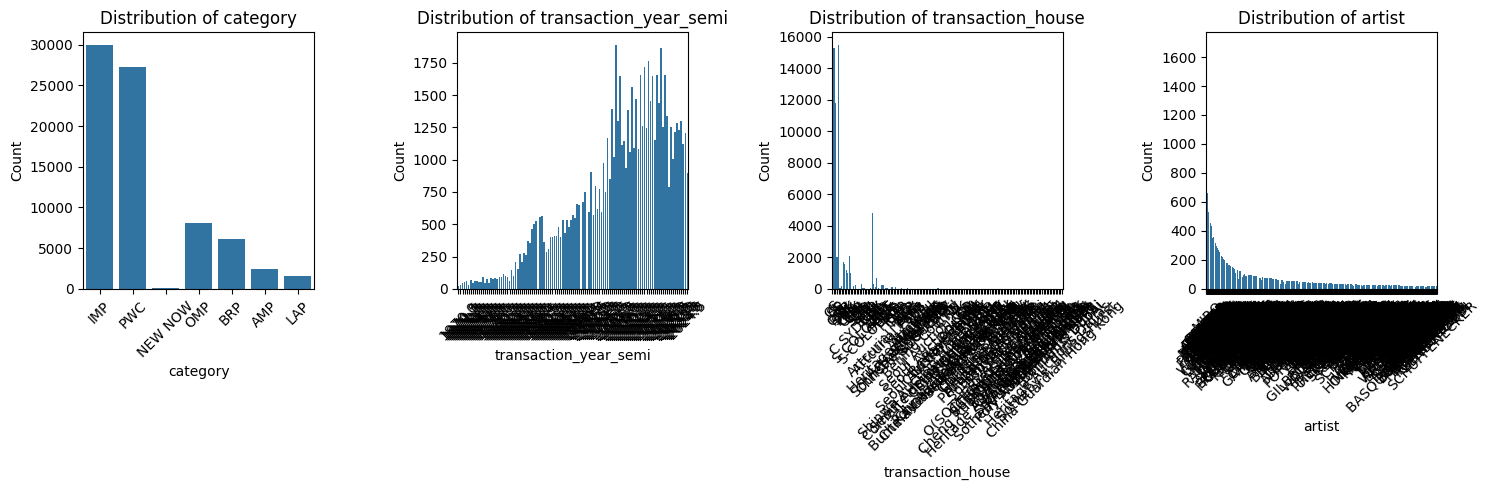

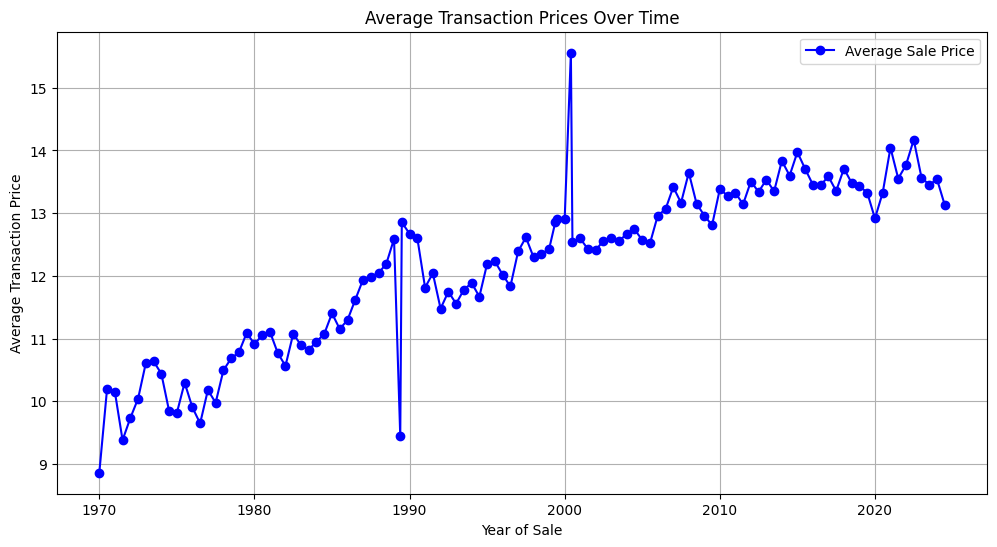

In [17]:
if __name__ == "__main__":


  drive.mount('/content/drive')
  artist_data_path= "/content/drive/My Drive/artist_graph_data.xlsx"
  artwork_numeric_data = pd.read_excel(artist_data_path)

  # Define source and destination paths
  source_path = "/content/drive/My Drive/Colab Notebooks/data_preprocess.ipynb"
  destination_path = "/content/drive/My Drive/data_preprocess.ipynb"

  # Check if the source file exists before moving
  if os.path.exists(source_path):
    # Move the file
    shutil.move(source_path, destination_path)
    print(f"Notebook moved to: {destination_path}")

  # visualizations

  print(artwork_numeric_data.shape)

  visualization_data = repeated_to_single_transactions(artwork_numeric_data)
  print(visualization_data.shape)

  #plot_avg_sale_prices_over_time(visualization_data)
  categorical_columns = ['category', 'transaction_year_semi', 'transaction_house', 'artist']
  plot_categorical_features(visualization_data, categorical_columns)

  plot_avg_sale_prices_over_time(visualization_data)



  # image

  """
  zip_path = "/content/drive/My Drive/pic.zip"
  extract_path = "/content/data"
  load_image_data(zip_path, extract_path)
  # Check for missing images
  base_dir = "/content/data"
  image_paths = artwork_numeric_data['image_url'].values
  missing_images = check_image_existence(image_paths, base_dir)
  data_filtered = filter_data_for_missing_images(artwork_numeric_data, missing_images, base_dir)
  # check functioning of image data after filtering
  print(f"After filtering:{check_image_existence(data_filtered['image_url'],base_dir)} ")

  """
